## Model Basics with modelr

In [1]:
library (tidyverse)
library (modelr)
options (na.action = na.warn)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


### A Simple Model

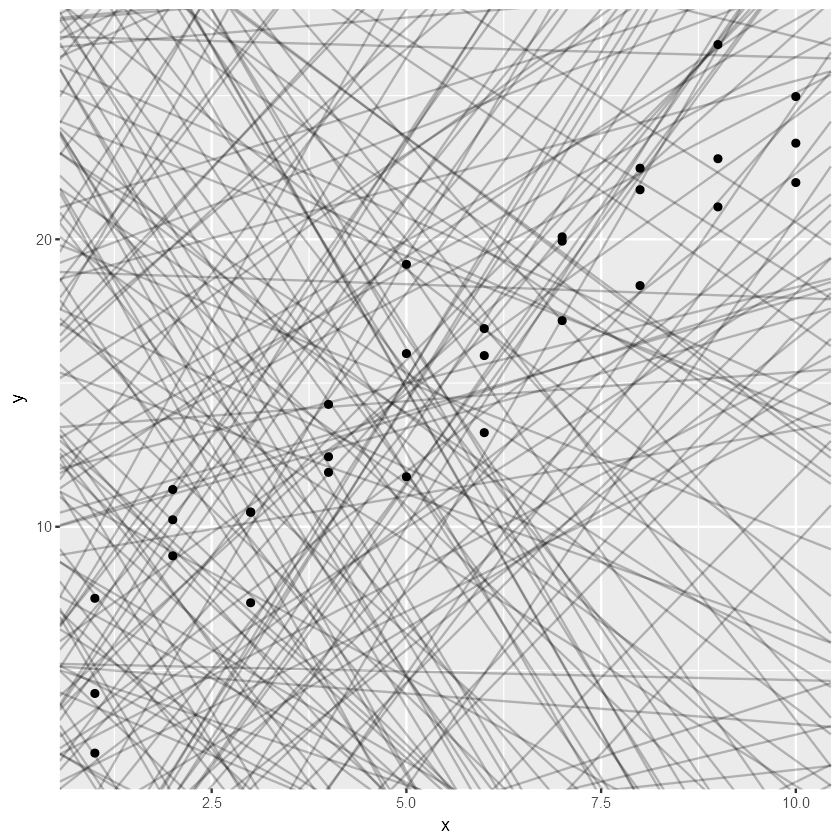

In [5]:
## 適当にモデルをいろいろと考えてみる
models <- tibble (
    a1 = runif (250, -20, 40), 
    a2 = runif (250,  -5,  5)
)

ggplot(sim1, aes(x, y)) + 
    geom_abline (
        aes (intercept = a1, slope = a2), 
        data = models, alpha = 1/4
    ) + 
    geom_point()


In [7]:
# 残差二乗和を使ってモデルとデータの距離を求める
model1 <- function (a, data) {
    a[1] + data$x * a[2]
}
measure_distance <- function (mod, data) {
    diff <- data$y - model1 (mod, data)
    sqrt (mean (diff^2))
}
sim1_dist <- function (a1, a2) {
    measure_distance(c(a1, a2), sim1)
}
models <- 
    models %>% 
    mutate (dist = map2_dbl(a1, a2, sim1_dist))
models %>% print()

# A tibble: 250 x 3
           a1         a2      dist
        <dbl>      <dbl>     <dbl>
 1  0.8575216 -0.6582737 19.970010
 2 26.0451669 -4.2369649 22.218366
 3  2.7671601  2.4398658  2.497724
 4 -7.6261425  4.5513674  7.726765
 5 11.0906090  1.4003647  4.340580
 6 11.6490750  0.6680416  4.511408
 7 36.2529270  0.2344492 22.747500
 8 35.0138047  1.1547273 26.075513
 9 26.7238719 -1.1912051 10.633482
10  8.7622920  0.4596744  6.571946
# ... with 240 more rows


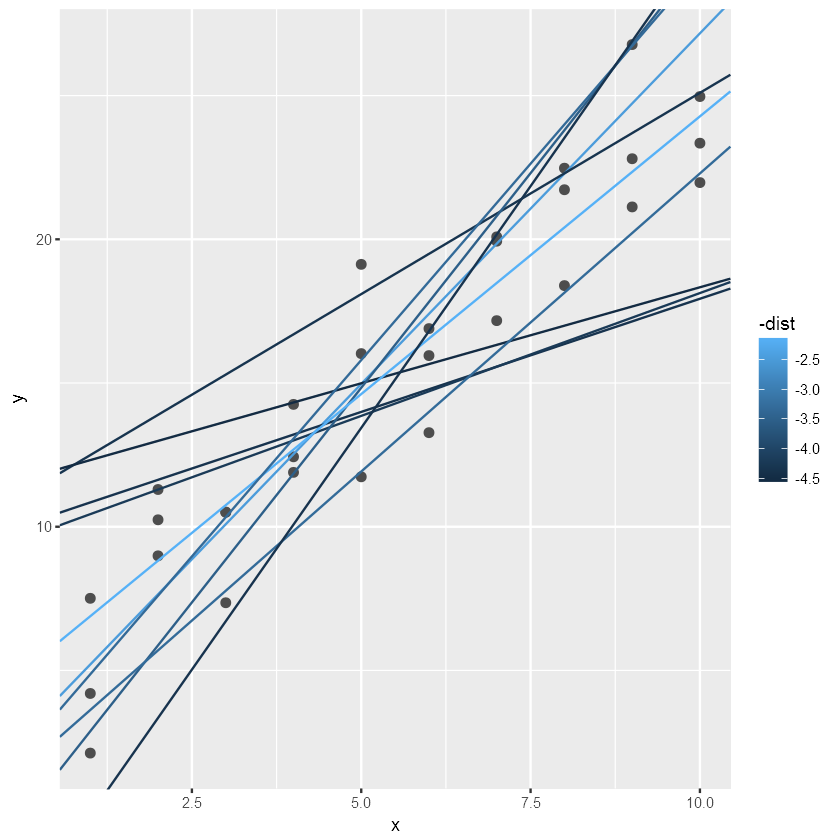

In [8]:
## 上位十モデルをプロットす
ggplot(sim1, aes(x, y)) + 
    geom_point (size = 2, color = "grey30") + 
    geom_abline (
        aes(intercept = a1, slope = a2, color = -dist), 
        data = filter (models, rank(dist) <= 10)
    )

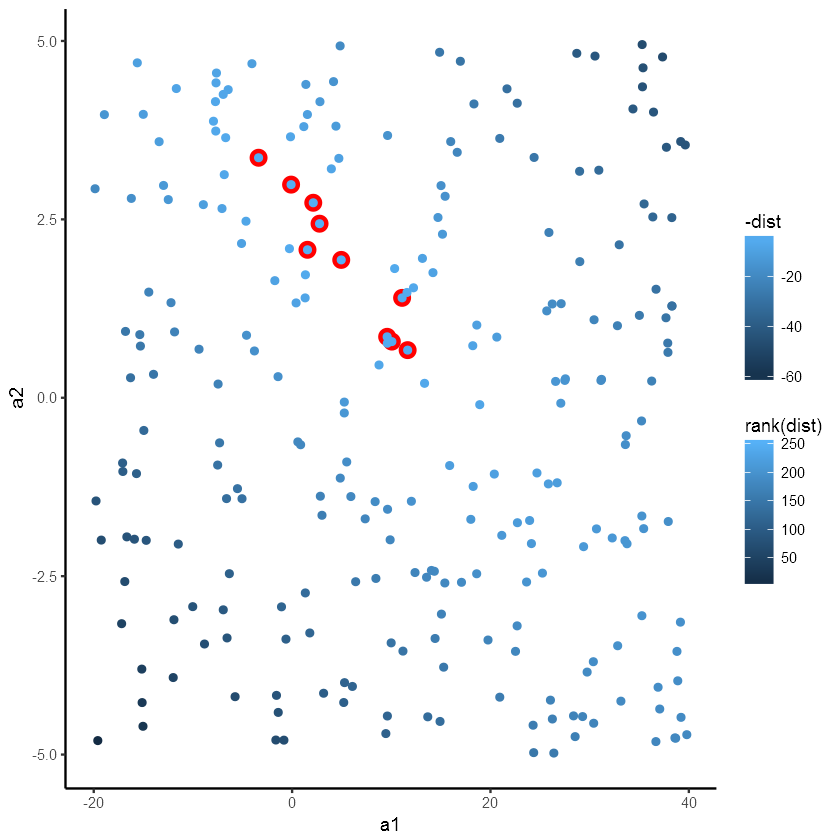

In [11]:
## 上位10個のモデルのパラメータをプロットしてみる
ggplot(models, aes(a1, a2)) + 
    geom_tile (aes(fill=rank(dist))) + 
    geom_point (
        data = filter (models, rank(dist) <= 10), 
        size = 4, color = "red"
    ) + 
    geom_point(aes(color=-dist)) + 
    theme_classic()

In [21]:
## このようにしてランダム二推定する方法もよいが数値最適化が可能である
best <- optim(c (0,0), measure_distance, data=sim1)
best$par

[1] 4.222248 2.051204

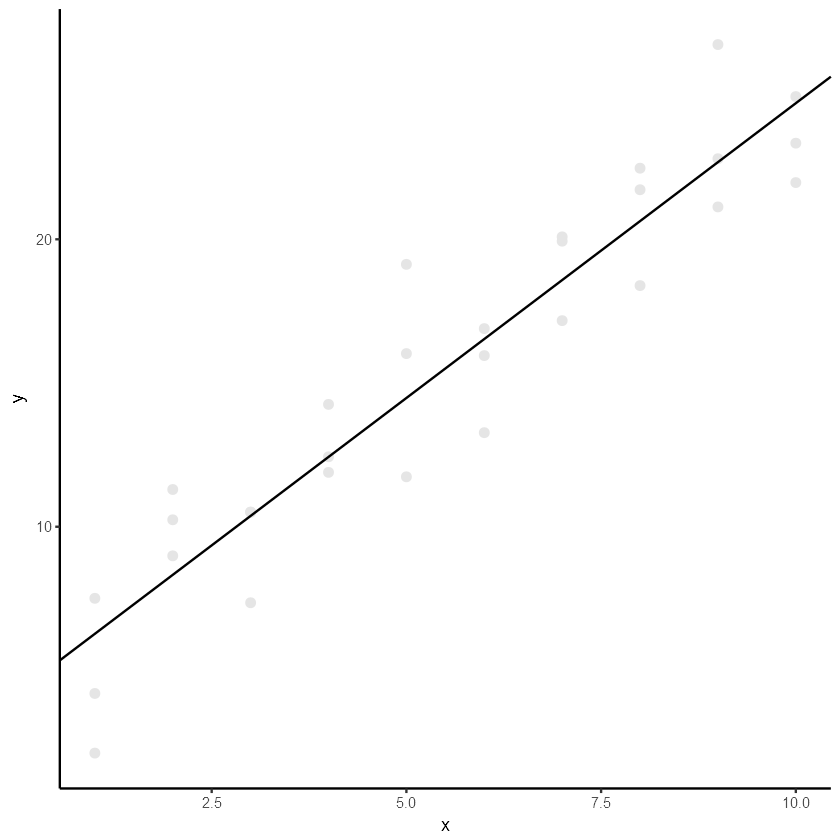

In [23]:
ggplot(sim1, aes(x, y)) + 
    geom_point (size=2, color="grey90") + 
    geom_abline (intercept = best$par[1], slope = best$par[2]) + 
    theme_classic()

### Visualizing Models


In [33]:
library (modelr)
sim1_mod <- lm (y ~ x, data = sim1)

In [31]:
## モデルをビジュアライズするために, modelrを駆使して, 当感覚のグリッド値を考える
## 引数のユニークな組み合わせを返す
grid <- 
    sim1 %>%
    data_grid(x);
grid;

x
1
2
3
4
5
6
7
8
9
10


In [34]:
## 作成済みのモデルに, xを当てはめてみる
grid <- grid %>%
    add_predictions(sim1_mod);
grid

x,pred
1,6.272355
2,8.323888
3,10.375421
4,12.426954
5,14.478487
6,16.530020
7,18.581553
8,20.633087
9,22.684620
10,24.736153


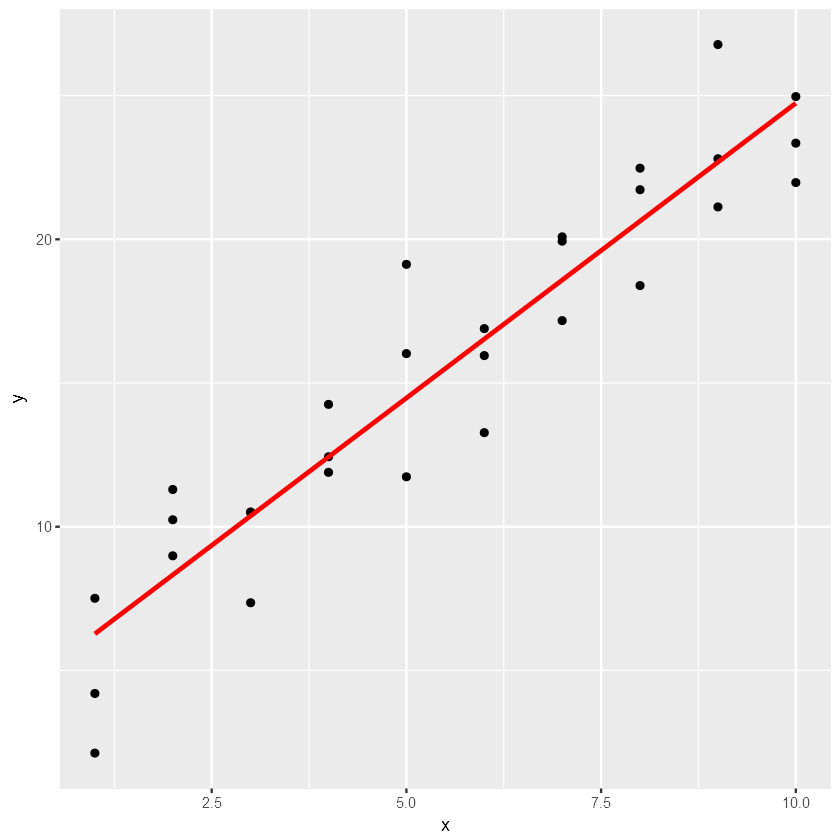

In [36]:
## 結果をプロット
ggplot(sim1, aes(x, y)) + 
    geom_point() + 
    geom_line (aes(y = pred), data=grid, color="red", size=1)

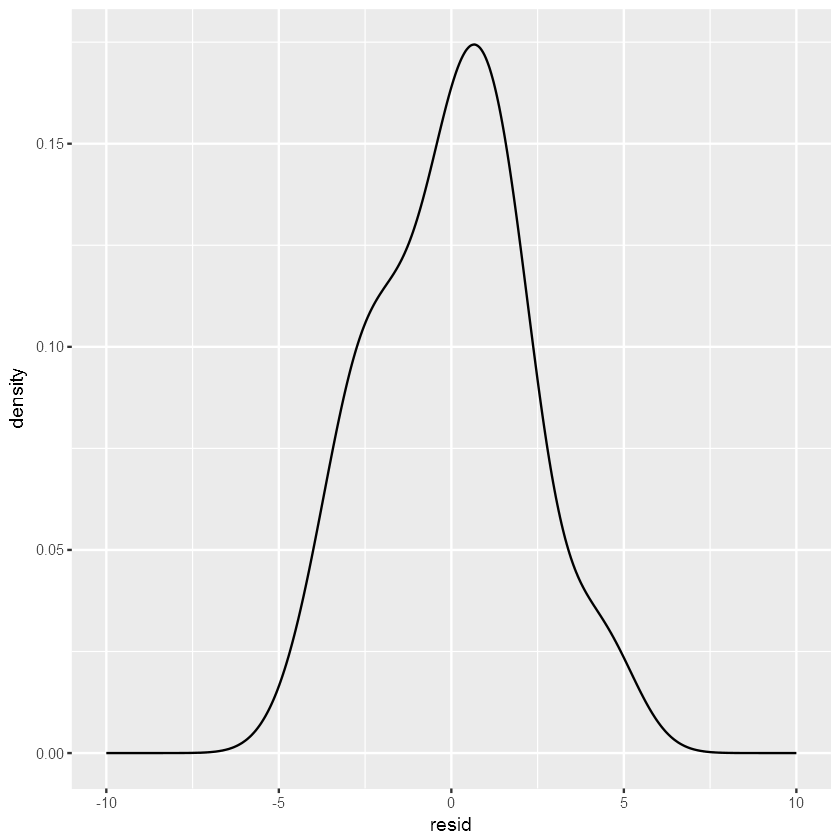

In [97]:
## 残差
sim1 <- sim1 %>%
    add_residuals(sim1_mod)
sim1 %>%
    ggplot(aes(resid)) + stat_density(position="identity", geom="line") + xlim(c(-10, 10))

### Formulas and Model Families

In [47]:
df <- tribble(
    ~y, ~x1, ~x2, 
    4, 2, 5, 
    5, 1, 6
)
model_matrix(df, y ~ x1) # 切片なしは+0

(Intercept),x1
1,2
1,1


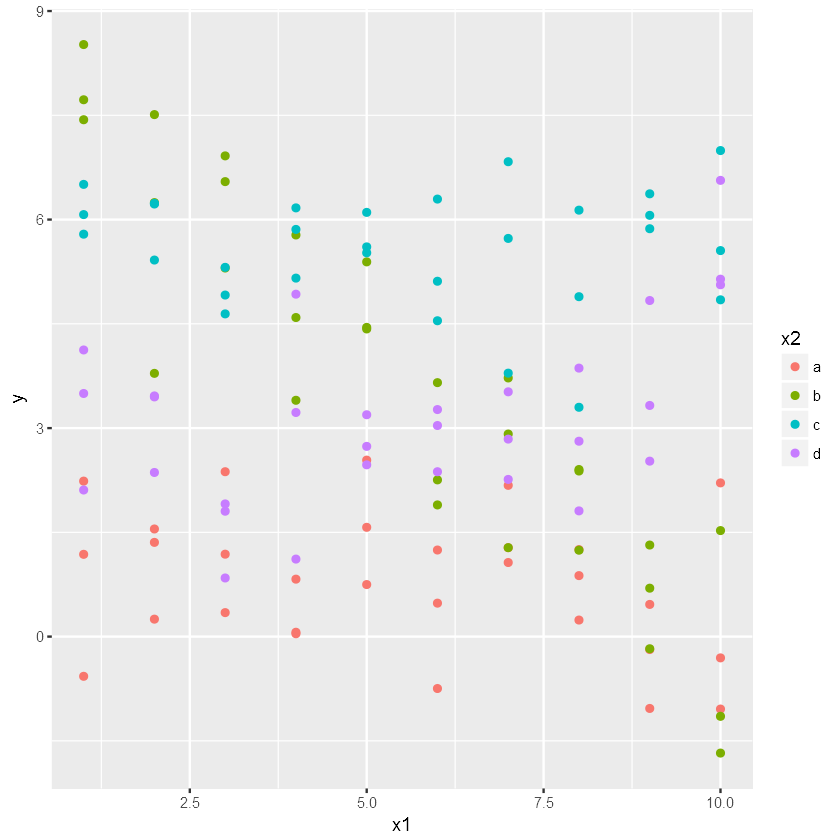

In [49]:
## formula を model_matrixで
ggplot(sim3, aes(x1, y)) + 
    geom_point(aes(color=x2))

In [50]:
mod1 <- lm (y ~ x1 + x2, data = sim3)
mod2 <- lm (y ~ x1 * x2, data = sim3)

grid <- sim3 %>%
    data_grid(x1, x2) %>%
    gather_predictions(mod1, mod2) # モデルの予測結果を行方向につなげてくれる
grid

model,x1,x2,pred
mod1,1,a,1.6749281
mod1,1,b,4.5627390
mod1,1,c,6.4806640
mod1,1,d,4.0345149
mod1,2,a,1.4781904
mod1,2,b,4.3660012
mod1,2,c,6.2839262
mod1,2,d,3.8377771
mod1,3,a,1.2814526
mod1,3,b,4.1692635


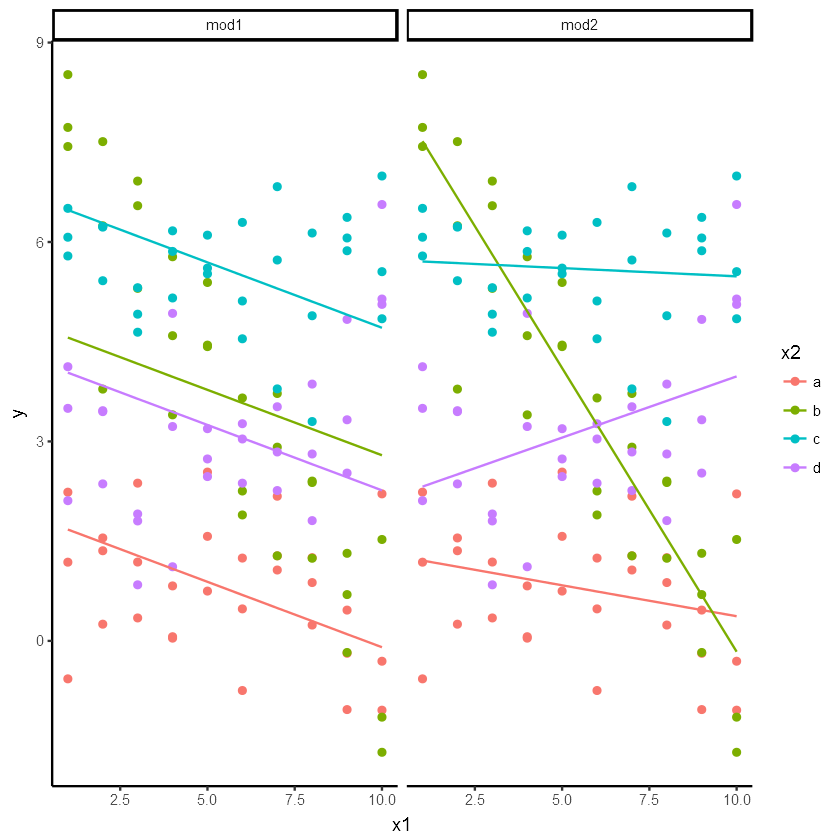

In [57]:
## 交互作用を考慮したモデル2の方がデータを捉えているように見える.
ggplot(sim3, aes(x1, y, color=x2)) + 
    geom_point() + 
    geom_line(data=grid, aes(y = pred)) + 
    facet_wrap(~model) + 
    theme_classic()

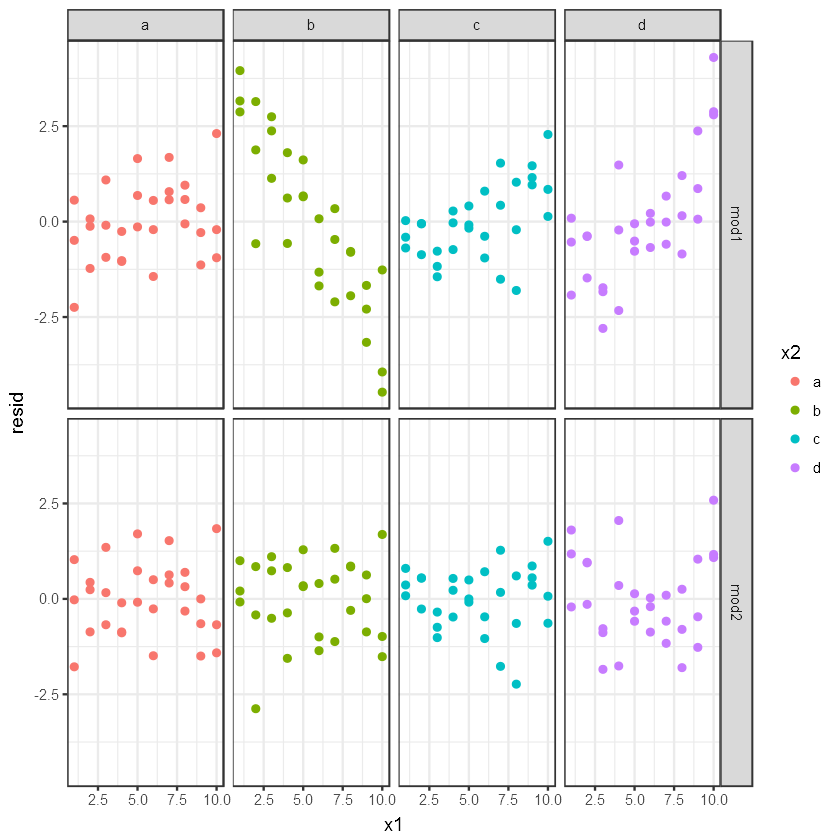

In [58]:
## 残差で確認する -> やはりモデル2の方が適切に見える
sim3 <- 
    sim3 %>%
    gather_residuals(mod1, mod2)
ggplot(sim3, aes(x1, resid, color=x2)) + 
    geom_point() + 
    facet_grid(model ~ x2) + 
    theme_bw()

In [60]:
## crossingのラッパー
data_grid

function (data, ..., .model = NULL) 
{
    expanded <- tidyr::expand(data, ...)
    if (is.null(.model)) 
        return(expanded)
    needed <- setdiff(predictor_vars(.model), names(expanded))
    typical <- tidyr::crossing_(lapply(data[needed], typical))
    tidyr::crossing(expanded, typical)
}
<environment: namespace:modelr>

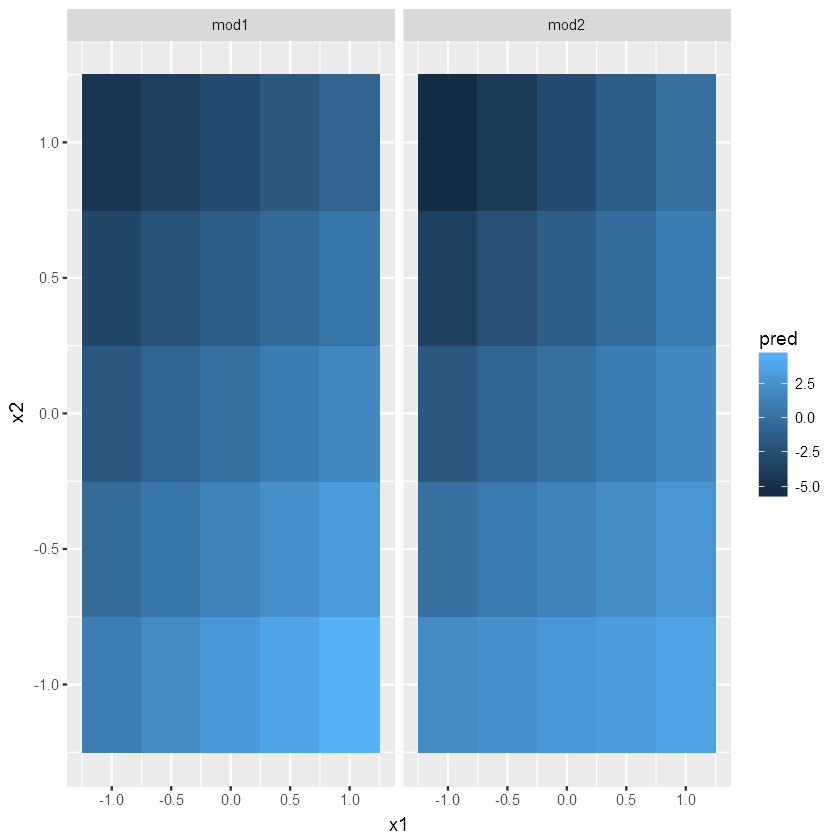

In [63]:
## Interactions
mod1 <- lm (y ~ x1 + x2, data=sim4)
mod2 <- lm (y ~ x1 * x2, data=sim4)

grid <- sim4 %>%
    data_grid(
        x1 = seq_range(x1, 5),  # rangeの領域を5段階で
        x2 = seq_range(x2, 5)
    ) %>%
    gather_predictions(mod1, mod2)

ggplot(grid, aes(x1, x2)) + 
    geom_tile(aes(fill=pred)) +
    facet_wrap( ~ model)


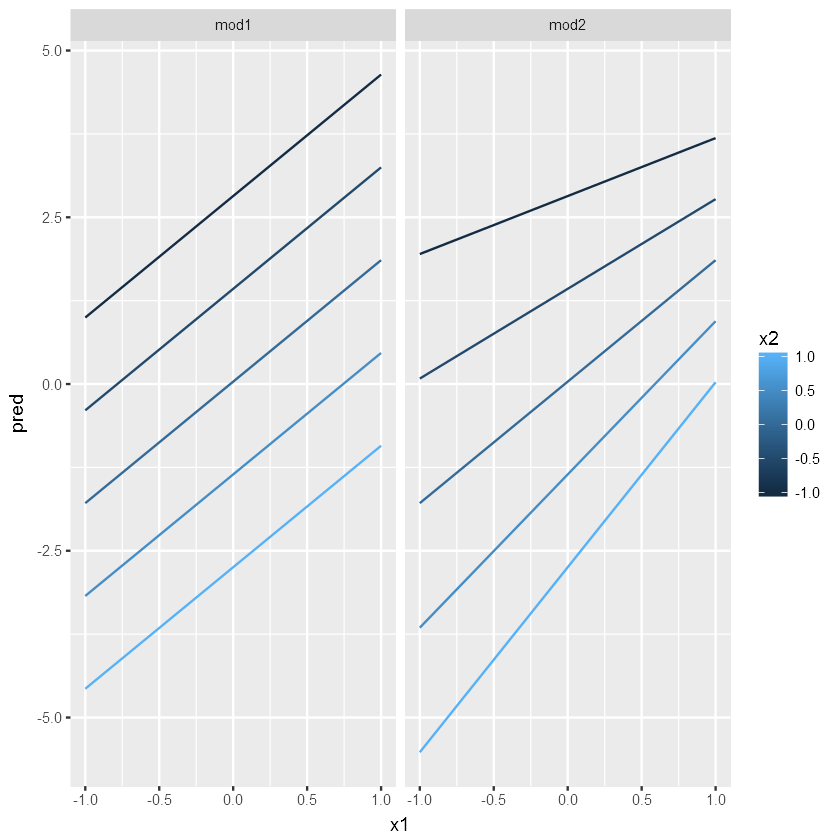

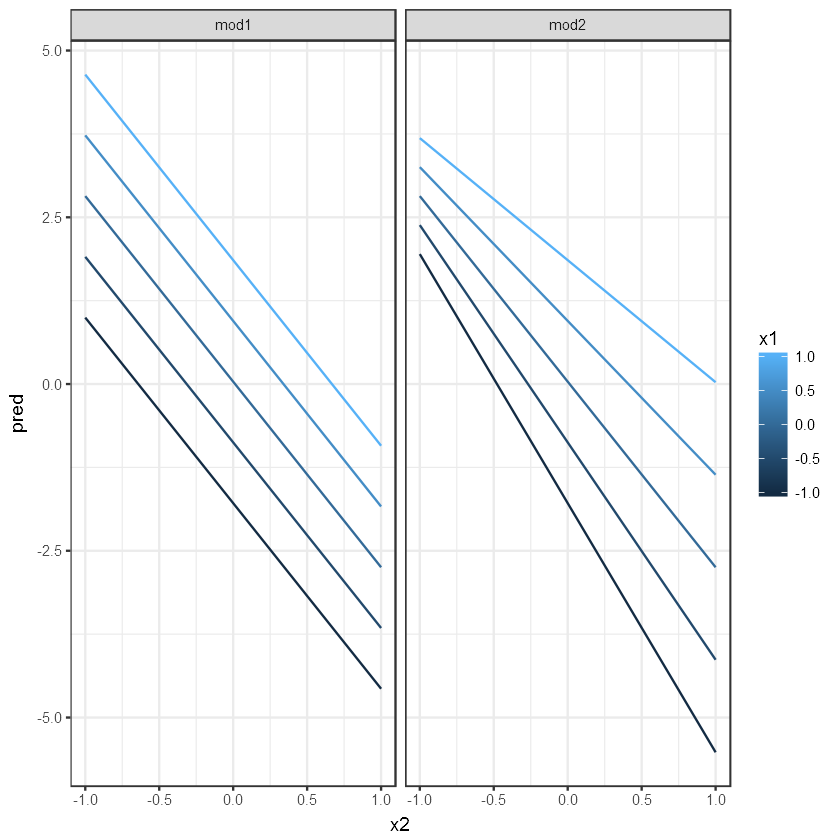

In [64]:
ggplot(grid, aes(x1, pred, color=x2, group=x2)) +
    geom_line() + 
    facet_wrap( ~ model)
ggplot(grid, aes(x2, pred, color=x1, group=x1)) + 
    geom_line() + 
    facet_wrap(~model) + 
    theme_bw()

In [66]:
## formulaで多項式を扱う場合にはI(x^2)やpoly(x, 2)を使う
## ここではスプラインバージョンを紹介
library (splines)
df <- tribble (
    ~ y, ~ x, 
    1, 1,
    2, 2, 
    3, 3
)
model_matrix(df, y ~ ns(x, 2))

(Intercept),"ns(x, 2)1","ns(x, 2)2"
1,0.0000000,0.0000000
1,0.5662628,-0.2108419
1,0.3440969,0.7706021


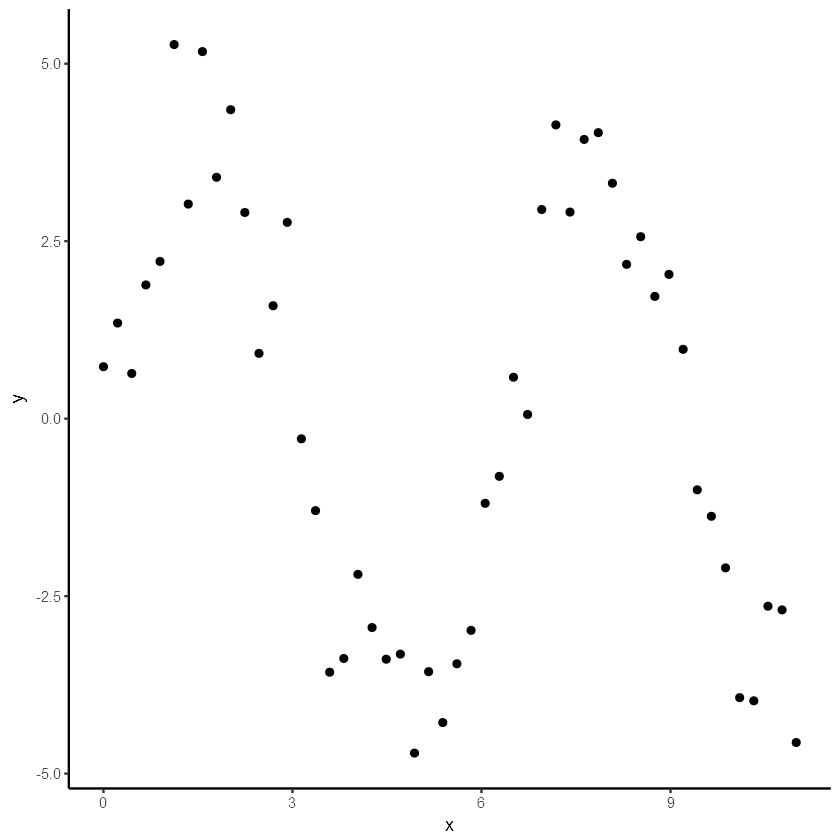

In [67]:
sim5 <- tibble (
    x = seq(0, 3.5 * pi, length = 50), 
    y = 4 * sin (x) + rnorm(length(x))
)

ggplot(sim5, aes(x, y)) + 
    geom_point() + 
    theme_classic()




In [89]:
model_df <- 1:5
models   <- model_df %>% map( ~ lm(y ~ ns(x, .),  data=sim5)) %>% set_names(paste0("df", model_df))
models

$df1

Call:
lm(formula = y ~ ns(x, .), data = sim5)

Coefficients:
(Intercept)     ns(x, .)  
      1.603       -3.802  


$df2

Call:
lm(formula = y ~ ns(x, .), data = sim5)

Coefficients:
(Intercept)    ns(x, .)1    ns(x, .)2  
      2.412       -5.572       -1.468  


$df3

Call:
lm(formula = y ~ ns(x, .), data = sim5)

Coefficients:
(Intercept)    ns(x, .)1    ns(x, .)2    ns(x, .)3  
      5.163        1.825      -14.697       -2.982  


$df4

Call:
lm(formula = y ~ ns(x, .), data = sim5)

Coefficients:
(Intercept)    ns(x, .)1    ns(x, .)2    ns(x, .)3    ns(x, .)4  
      2.144      -10.064        6.176       -2.615       -9.415  


$df5

Call:
lm(formula = y ~ ns(x, .), data = sim5)

Coefficients:
(Intercept)    ns(x, .)1    ns(x, .)2    ns(x, .)3    ns(x, .)4    ns(x, .)5  
     0.2723      -9.5272       2.8434       0.9346       3.2974      -9.6382  



In [94]:
grid5 <- sim5 %>%
    data_grid(x = seq_range(x, n= 50, expand=.1)) %>%
    gather_predictions(models[["df1"]], models[["df2"]], models[["df3"]], models[["df4"]], models[["df5"]], 
                      .pred="y"); 
grid5 %>% head

model,x,y
"models[[""df1""]]",-0.54977871,1.755658
"models[[""df1""]]",-0.30293929,1.687231
"models[[""df1""]]",-0.05609987,1.618803
"models[[""df1""]]",0.19073955,1.550376
"models[[""df1""]]",0.43757898,1.481949
"models[[""df1""]]",0.68441840,1.413522


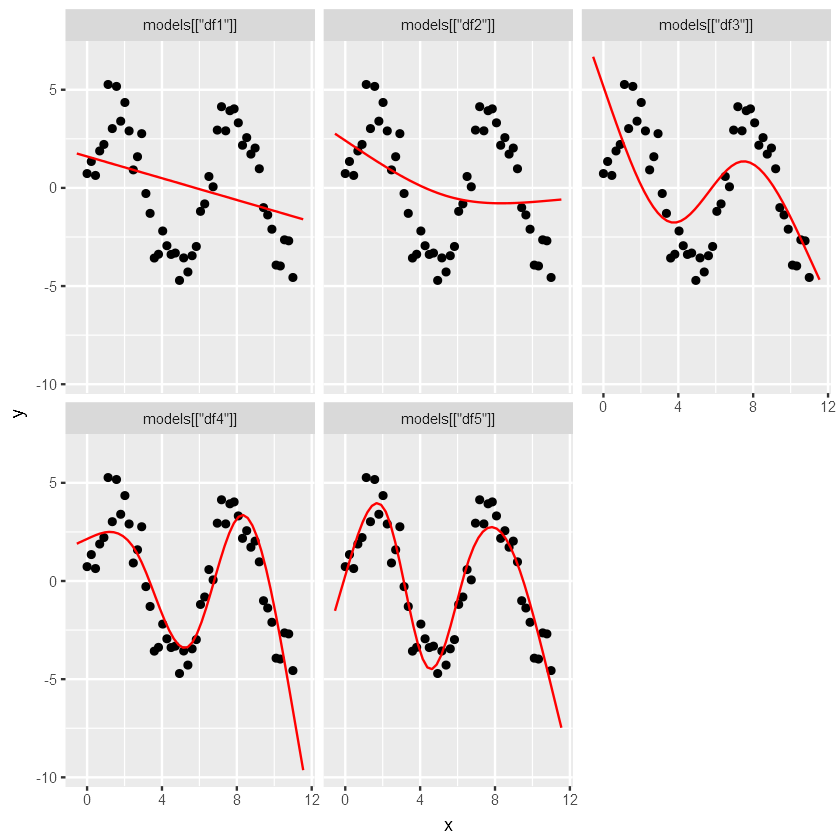

In [95]:
ggplot(sim5, aes(x, y)) + 
    geom_point() + 
    geom_line(data=grid5, color="red") + 
    facet_wrap( ~ model)